![](imagenes/UC_FMRI.jpg)

---
---

***Andres Eduardo Aracena Rangel***

*Estudiante del programa del Magister en Física Médica*

---
---

El siguiente Script de Python forma parte del trabajo especial de grado.

Profesora Guía:

*PhD María Daniela Cornejo*

---

---

El siguiente Script de Python forma parte del trabajo especial de grado.

&nbsp;
Con referencia:

- [Pagina oficial NIbabel](https://nipy.org/nibabel/index.html) 

Imagenes de fMRI extraidas de OpenNuero:
 
 - [ds002422](https://openneuro.org/datasets/ds002422/versions/1.1.0)
 
 ---
 Acronimos:

- CSF: Cerebrospinal Fluid (*líquido cefalorraquídeo*)
- GM: Gray Matter (*materia gris*)
- WM: White Matter (*materia blanca*)
---
NOTA:
Cuando indiquemos imagenes brain o mascaras brain, nos estamos refieriendo a las imagenes o mascaras de csf, wm, gm

# Visualización mascaras csf, wm y gm resultantes del preprocesamiento

## Importamos librerias

In [1]:
import time # medir el tiempo de ejecución de nuestros programas
start = time.process_time()
inicio = time.time()

In [2]:
import os # El módulo os nos permite acceder a funcionalidades dependientes del Sistema Operativo
from os.path import join as opj # Este método concatena varios componentes de ruta con exactamente un separador de directorio(‘/’)

from nipype import SelectFiles

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from nilearn.plotting import plot_anat
%matplotlib inline

220720-01:18:35,586 nipype.utils WARNING:
	 A newer version (1.8.3) of nipy/nipype is available. You are using 1.7.0


/home/aracena/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [3]:
from nilearn.plotting import plot_anat

In [4]:
'''
Ruta del directorio de la data
'''
path_data = '/home/aracena/thesis_ds002422/' 

'''
Ruta donde reposa la imagen funcional procesada
'''
path_fmri = opj(path_data,'01_fase1_extraccion_mask_brain','output','datasink','fmri_detrend',
                'mask_ext_csf', 'threshold_0.95')

'''
Ruta mascaras brain
'''
path_brain = opj(path_data,'01_fase1_extraccion_mask_brain','output','datasink','masks_brain')

'''
Ruta donde reposan las imagenes de referencia de los cortes anatomicos
'''
path_ref = opj(path_data,'01_fase1_extraccion_mask_brain', 'imagenes')


'''
lista de tejidos a procesar
'''
tejido = ['mask_csf', 'mask_gm', 'mask_wm']

        
'''
Ingrese el umbral que desea extraer (se extrajeron tres mask brain para tres umbrales distintos)
'''
umbral_sel = '0.5'

## Funciones

### Función atributos

In [5]:
'''
Función para extraer los atributos de la(s) imagen(es).

Inputs:

- img: Diccinario con las imagenes nifti

Output:

df_atri: Dataframe con los principales atributos de las imagenes contenidas en el diccionario 'img'
'''

def atributo_img(img):
    import pandas as pd
    lista_img = list(img.keys()) # Creamos una lista con las claves del diccionario

    df_atri = pd.DataFrame()
    df_atri.index = ['forma', 'dimension', 'orientacion', '', 'x_img', 'y_img' , 'z_img', 'volumenes_(N)', 'voxel_size_(mm)', 
                       'TR_(s)', 'tipo_dato', 'numero_voxels','min_img', 'max_img']
    
    for i, ima in enumerate(lista_img):
        lista_atri = []
        #cargamos el header de la imagen
        header_img = img[ima].header
        
        # Forma y dimensión de la imágen
        forma = header_img.get_data_shape() 
        lista_atri.append(str(forma))
        lista_atri.append(len(forma))
        
        # Orientacion de la imágen
        orientacion = nib.orientations.aff2axcodes(img[ima].affine)
        lista_atri.append(orientacion)

        # x, y, z y volumenes
        ejes=[]
        for i in range(len(orientacion)):
            tam = img[ima].shape[i]
            ori = str(orientacion[i])
            if  ori == 'L'or ori == 'R':
                x_img = tam
                a = 'x'

            elif ori == 'A' or ori == 'P':
                y_img = tam
                a = 'y'

            elif ori == 'I'or ori == 'S':
                z_img = tam
                a = 'z'
                
            ejes.append(a)
        
        # Agregamos a la lista de atributos forma, x, y, z
        lista_atri.append(ejes)
        lista_atri.append(x_img)
        lista_atri.append(y_img)
        lista_atri.append(z_img)
        
        # Agregamos volumes a la lista de atributos 
        if len(forma) == 4:
            lista_atri.append(forma[-1])
        else:
            lista_atri.append('1')

        # Tamaño del voxel
        tavo = header_img.get_zooms()[0:3]
        
        tamvox=[]
        for i in range(len(tavo)):
            tamvox.append(round(tavo[i],3))
            
        lista_atri.append(tamvox) 
        
        # Tiempo de exploración
        if len(header_img.get_zooms()) == 4:
            lista_atri.append(header_img.get_zooms()[-1])
        else:
            lista_atri.append('---')     
        
        
        #lista_atri.append(header_img.get_zooms()[-1])   # Tiempo de exploración
        lista_atri.append(header_img.get_data_dtype())   # Tipo de datos numérico
        lista_atri.append(img[ima].get_fdata().size) # Número de elementos de la matriz
        lista_atri.append(round(img[ima].get_fdata().min(),2)) # Valor minimo de la imágen
        lista_atri.append(round(img[ima].get_fdata().max(),2)) # Valor maximo de la imágen
        
        # Creamos DF de atributos de la imagen
        df_at = pd.DataFrame()
        df_at = pd.DataFrame(lista_atri)
        df_at.columns = [ima]
        df_at.index = df_atri.index
        #display(df_at)

        # Unimos las DF
        df_atri = pd.merge(df_atri, df_at,
                           right_index=True,left_index=True)
    return df_atri

### Función visual_cortes_ana

In [6]:
'''
Función para generar la visualización de los cortes anatómico de varias imágenes (hasta cuatro) 

Inputs:

- img: Diccionario con las imágenes nifti
- vol: Volumen donde se desea visualizar los cortes anatómicos
- vox: Posición i,j,k del voxel sobre el cual se proyectarán los cortes
#- nom_img = nombre de la imagen con que se desea visualizar y guardar

Outputs:
- plot de los diferentes cortes anatómicos sobre un voxel de las imágenes ingresadas en 'img'
'''

def visual_cortes_ana(img, vol, voxel):
    import nibabel as nib
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
   
    # Creamos una lista con las claves del diccionario ingresado
    lista_img = list(img.keys())

    corte_sag = {}
    corte_cor = {}
    corte_axi = {}
    datos_img = {}
    x_cor = {}
    y_cor = {}
    z_cor = {}
    nomb_ori={}
    for i, ima in enumerate(lista_img):
        # Orientacion de la imágen
        orientacion = nib.orientations.aff2axcodes(img[ima].affine)
        # creamos un nombre para la grafica
        a = ','.join(orientacion)
        nomb_ori[ima] = '('+ a +')'
        
        #cargamos datos de la imagen
        datos_img[ima] = img[ima].get_fdata()
        ta = len(datos_img[ima].shape)
        if ta == 4:
            datos_img[ima] = datos_img[ima][...,vol]
        else:
            datos_img[ima] = datos_img[ima][...]

        #se extraen valores x, y, z del voxel ingresado y cortes segun posición anatómica
        for j in range(len(orientacion)):
            ori = str(orientacion[j])

            if  ori == 'L'or ori == 'R':
                x_cor[ima] = voxel[j]
                
                # corte segun posición anatómica
                if j == 0:
                    corte_sag[ima] = datos_img[ima][x_cor[ima],:,:]
                elif j == 1:
                    corte_sag[ima] = datos_img[ima][:,x_cor[ima],:]
                elif j == 2:
                    corte_sag[ima] = datos_img[ima][:,:,x_cor[ima]]

            elif ori == 'A' or ori == 'P':
                y_cor[ima] = voxel[j]
                
                # corte segun posición anatómica
                if j == 0:
                    corte_cor[ima] = datos_img[ima][y_cor[ima],:,:]
                elif j == 1:
                    corte_cor[ima] = datos_img[ima][:,y_cor[ima],:]
                elif j == 2:
                    corte_cor[ima] = datos_img[ima][:,:,y_cor[ima]]

            elif ori == 'I'or ori == 'S':
                z_cor[ima] = voxel[j]
                
                # corte segun posición anatómica
                if j == 0:
                    corte_axi[ima] = datos_img[ima][z_cor[ima],:,:]
                elif j == 1:
                    corte_axi[ima] = datos_img[ima][:,z_cor[ima],:]
                elif j == 2:
                    corte_axi[ima] = datos_img[ima][:,:,z_cor[ima]]
    
    # Definimos estilo de letra para la grafica
    font1 = {'fontsize':18, 'fontweight':'bold', 'color':'tab:blue'}
    font2  = {'fontsize':18, 'fontweight':'bold', 'color':'tab:red'}
    
    if (len(lista_img))==1:
        #Graficamos
        nom = lista_img[0] + '\n' + nomb_ori[lista_img[0]]

        fig, axes = plt.subplots(1,3, figsize=(15, 15))
        fig.suptitle(nom, fontweight ="bold", fontsize = 22, color = 'tab:blue')
        axes[0].imshow(corte_sag[ima], cmap = 'gray')
        axes[1].imshow(corte_cor[ima], cmap = 'gray')
        axes[2].imshow(corte_axi[ima], cmap = 'gray')
        for i in range(3):
            axes[i].axis('off')

        # Titulos de las graficas
        titulo =['Corte Sagital: '+ str(x_cor[ima]) + '\n', 
                 'Corte Coronal: '+ str(y_cor[ima]) + '\n',
                 'Corte Axial: '+ str(z_cor[ima]) + '\n']

        for i, title in enumerate(titulo):
            axes[i].set_title(title, fontdict=font2)

        plt.subplots_adjust(#left=0.5,
                        #bottom=0.5, 
                        #right=0.7,
                        hspace=0.3,
                        top=1.26)
        fig.patch.set_facecolor('xkcd:white')
        plt.show()
    
    else:
        # Graficamos
        fig, axes = plt.subplots(3, len(lista_img),figsize=(20, 20))
        for i, im in enumerate(lista_img):
            axes[0,i].imshow(corte_sag[im], cmap = 'gray')
            axes[1,i].imshow(corte_cor[im], cmap = 'gray')
            axes[2,i].imshow(corte_axi[im], cmap = 'gray')

        
            # Identificamos los cortes
            titulo =['Corte Sagital: '+ str(x_cor[im]) + '\n', 
                     'Corte Coronal: '+ str(y_cor[im]) + '\n',
                     'Corte Axial: '+ str(z_cor[im]) + '\n']

            for j, title in enumerate(titulo):
                axes[j,i].xaxis.set_label_position('top')
                axes[j,i].set_xlabel(title, fontdict=font2)
            

        # Titulos que que identifica la imagen y la orientacion
        for i,im in enumerate(lista_img):
            axes[0,i].set_title((im+'\n'+nomb_ori[im]+'\n'), 
                                fontdict=font1)
        
        #for j in range(3):
            #for i in range(2):
                #axes[j,i].axis('off')

    
        plt.subplots_adjust(#left=0.5,
                            #bottom=0.5, 
                            #right=0.7,        
                            #hspace=0.3,
                            top=0.91)
    plt.show()
    
    # cargamos imagen de referencia de los cortes anatomicos
    img_cor_sag = mpimg.imread(opj(path_ref,'corte_sagital_ref.png'))
    img_cor_cor = mpimg.imread(opj(path_ref,'corte_coronal_ref.png'))
    img_cor_axi = mpimg.imread(opj(path_ref,'corte_axial_ref.png'))

    img_cor = [img_cor_sag,img_cor_cor,img_cor_axi]

    fig, axes = plt.subplots(1,3, figsize=(2,2))
    for i,imco in enumerate(img_cor):
        axes[i].imshow(img_cor[i])
        axes[i].axis('off')

    # para cambiar el espacio entre las subtramas de Matplotlib
    plt.subplots_adjust(left=0, 
                        bottom=0.1,  
                        right=7,  
                        top=0.9,  
                        wspace=1,  
                        hspace=0.4)
    #fig.tight_layout()
    fig.patch.set_facecolor('xkcd:white')
    plt.plot()

## Cargamos imagen funcional preprocesada con bet y datos de la  imagen funcional

In [7]:
img_func = 'fmri_rest_prepro.nii.gz'
img_func_orig = nib.load(opj(path_fmri,img_func)) # Cargamos imagen nifti
datos_func_orig = img_func_orig.get_fdata()       # Cargamos datos de la imagen
datos_func_orig.shape

(62, 62, 44, 196)

### Diccionario: Crear diccionario general de la imagenes y datos a procesar

El objetivo de guardar las imagenes y datos de las imagenes a procesar (imagenes funcional y mascaras brain) es para luego poder utilizar los respectivos datos de manera sencilla en bucles.
Se crea los siguientes diccionario general:

- 'img': para guaradar las imagenes a procesar
- 'datos_img': para guardar los datos de las imagenes a procesar

In [8]:
img = {'func_prepro': img_func_orig}
datos_img = {'func_prepro' : datos_func_orig}

## Cargamos imagen y datos de la imagenes de las mascaras brain

### Interfaz SelectFiles - mascaras brain

En esta oprtunidad, trabajaremos con interfaces y no con nodos, ya que queremos trabajar directamente y visualizar las mascaras.

Extramos las rutas de las mascaras para los umbrales previamente calculo en el notebook **01_fase1_extraccion_mask_brain**

In [9]:
# La entrada template indica la plantilla de cadena que debe coincidir en el directorio indicado a buscar
templates = {'mask_brain': 'mask_ext_*/threshold_{umbral}/fmri_rest_prepro.nii.gz'}
       
selectfiles = SelectFiles(templates)


'''
Inputs
- Ubicación de la carpeta del conjunto de datos
- Cadenas de marcador de posición {}
'''
# La entrada base_directory indica en que directorio buscar
selectfiles.inputs.base_directory = path_brain

#Ingresamos la(s) cadena(s) de marcador de posición {} con valores
selectfiles.inputs.umbral = umbral_sel

#selectfiles.inputs.tejido = [tejido]
#get_mask_ext.iterables = ('mask_ext', mask_ext)

# ejecutamos 
brain_mask = selectfiles.run().outputs

In [10]:
brain_mask


mask_brain = ['/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_csf/threshold_0.5/fmri_rest_prepro.nii.gz', '/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_gm/threshold_0.5/fmri_rest_prepro.nii.gz', '/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_wm/threshold_0.5/fmri_rest_prepro.nii.gz']

### Diccionarios para los mascaras tejido-umbrales

In [11]:
mask = dict(zip(tejido,brain_mask.mask_brain))
print('mask\n', mask)

mask
 {'mask_csf': '/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_csf/threshold_0.5/fmri_rest_prepro.nii.gz', 'mask_gm': '/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_gm/threshold_0.5/fmri_rest_prepro.nii.gz', 'mask_wm': '/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_wm/threshold_0.5/fmri_rest_prepro.nii.gz'}


### Diccionario: Cargamos imagenes nifti de mascaras

In [12]:
lista_brain = list(mask.keys()) # extraemos una lista de las mascaras

img_mask = {}
for i, tisue in enumerate(lista_brain):
    img_mask[tisue] = nib.load(mask[tisue])

print(img_mask['mask_csf'].shape)
print(img_mask['mask_wm'].shape)
print(img_mask['mask_gm'].shape)

(62, 62, 44, 196)
(62, 62, 44, 196)
(62, 62, 44, 196)


In [13]:
img_mask

{'mask_csf': <nibabel.nifti1.Nifti1Image at 0x7f4d23836130>,
 'mask_gm': <nibabel.nifti1.Nifti1Image at 0x7f4d2386f9d0>,
 'mask_wm': <nibabel.nifti1.Nifti1Image at 0x7f4d2386fb20>}

### Diccionario: cargamos datos de mascaras

In [14]:
datos_img_mask = {}
for i, tisue in enumerate(lista_brain):
    datos_img_mask[tisue] = img_mask[tisue].get_fdata()

print(datos_img_mask['mask_wm'].shape)

(62, 62, 44, 196)


### Diccionario: Agregamos las imagenes y datos de las imagenes da las mascaras brain al diccionario general

In [15]:
'''
Para añadir los pares clave-valor de un diccionario a otro, empleamos el método update().
'''

img.update(img_mask)
datos_img.update(datos_img_mask)

In [16]:
print(img)

{'func_prepro': <nibabel.nifti1.Nifti1Image object at 0x7f4d2386cd90>, 'mask_csf': <nibabel.nifti1.Nifti1Image object at 0x7f4d23836130>, 'mask_gm': <nibabel.nifti1.Nifti1Image object at 0x7f4d2386f9d0>, 'mask_wm': <nibabel.nifti1.Nifti1Image object at 0x7f4d2386fb20>}


## Extraemos los atributos de las imagen(es)

In [17]:
'''
Creamos diccionario de las imagenes (img) y datos de imagenes (datos_img)
'''
# Ya los diccionario img y datos_img estan creados en la lineas anteriores

'''
Ejecutamos la función atributo_img()
'''
atributo = atributo_img(img=img)
atributo

,func_prepro,mask_csf,mask_gm,mask_wm
forma,"(62, 62, 44, 196)","(62, 62, 44, 196)","(62, 62, 44, 196)","(62, 62, 44, 196)"
dimension,4,4,4,4
orientacion,"(P, S, R)","(P, S, R)","(P, S, R)","(P, S, R)"
,"[y, z, x]","[y, z, x]","[y, z, x]","[y, z, x]"
x_img,44,44,44,44
y_img,62,62,62,62
z_img,62,62,62,62
volumenes_(N),196,196,196,196
voxel_size_(mm),"[4.0, 4.0, 4.0]","[4.0, 4.0, 4.0]","[4.0, 4.0, 4.0]","[4.0, 4.0, 4.0]"
TR_(s),3.56,3.56,3.56,3.56


In [18]:
atributo['func_prepro']['x_img']

44

In [19]:
for i, im in enumerate(datos_img):
    print(im)

func_prepro
mask_csf
mask_gm
mask_wm


## Extraemos un volumen de las imagenes 4D para visualizar con plot_anat

In [20]:
vol = 0

vol_img={}

for i, im in enumerate(datos_img):
    vol_img[im] = img[im].slicer[...,vol]

print(vol_img['mask_gm'].shape)

(62, 62, 44)


## Graficamos

In [21]:
for i, im in enumerate(vol_img):
    print(im)

func_prepro
mask_csf
mask_gm
mask_wm


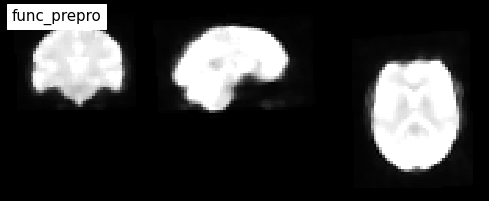

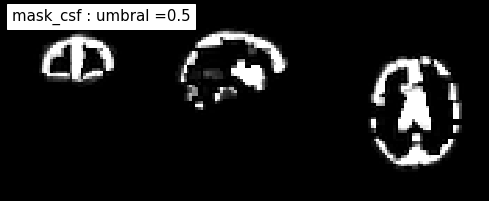

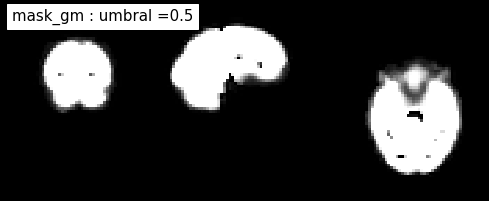

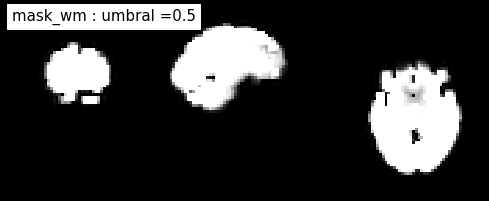

In [22]:
for i, im in enumerate(vol_img):
    if im == 'func_prepro':
        plot_anat(vol_img[im], title=im,
                  display_mode='ortho', dim=-1, draw_cross=False, annotate=False);
    else:
        plot_anat(vol_img[im], title=im+' : umbral ='+ umbral_sel,
                  display_mode='ortho', dim=-1, draw_cross=False, annotate=False);

## Ejecutamos función visual_cortes_ana

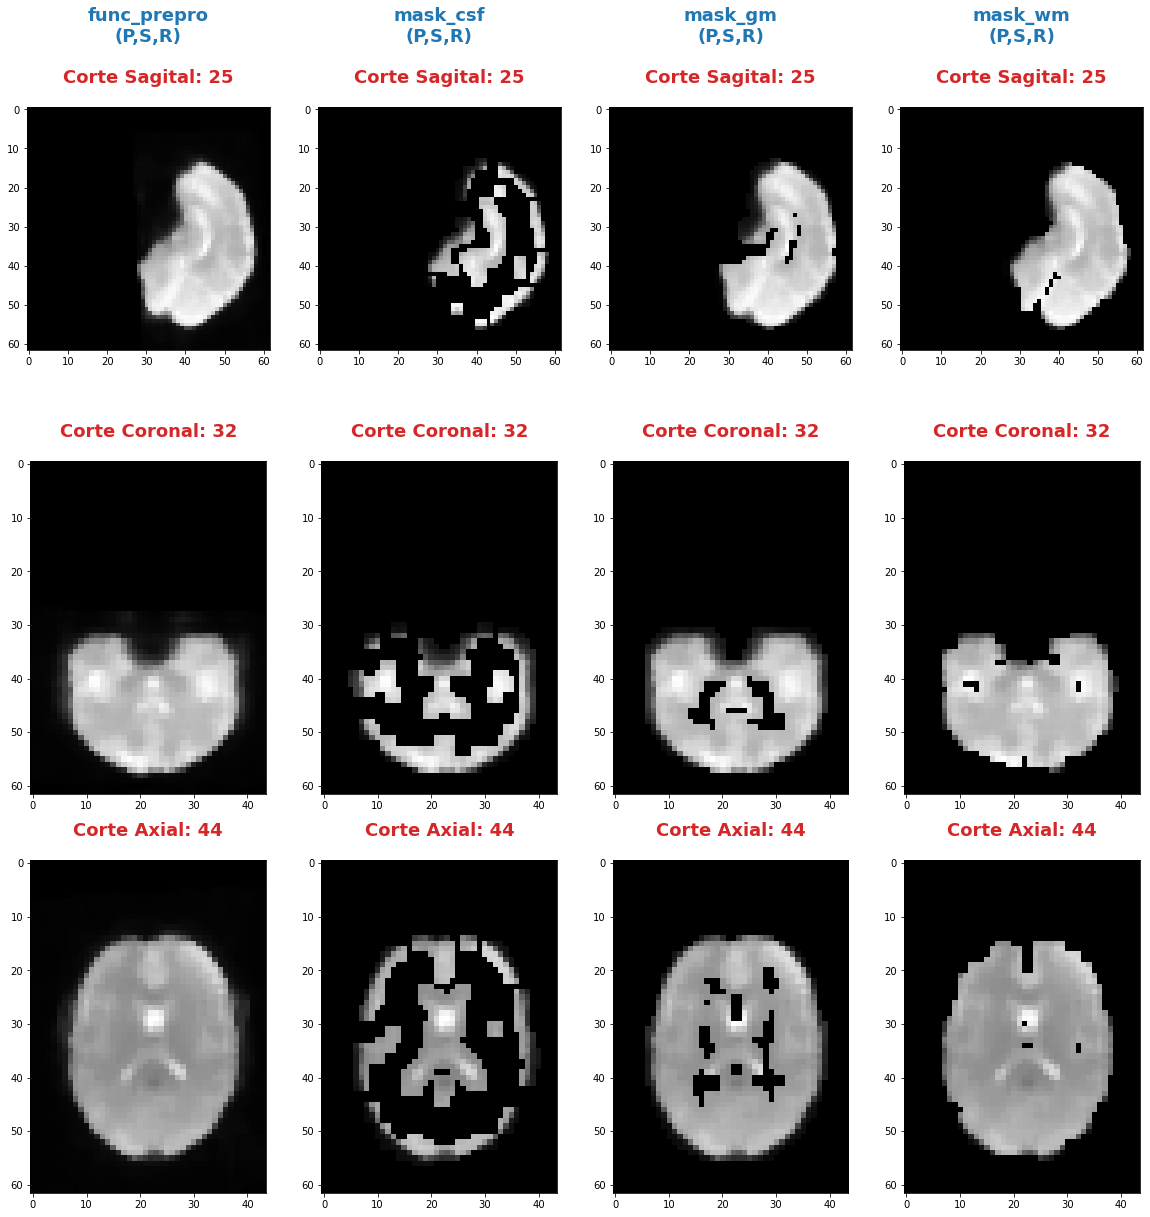

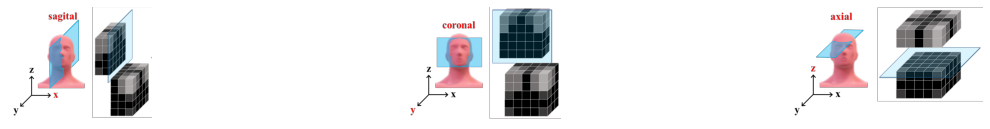

In [23]:
visual_cortes_ana(img= img,
                 vol= 0,
                 voxel=(32,44,25))

## Tiempo de ejecución

In [24]:
fin = time.time()
end = time.process_time()
tiempo = fin - inicio
tiempo2 = end - start

print('--------------------------------------')
print('tiempo de ejecución\n\n', round(tiempo,3), 'seg\n', round(tiempo/60,3), 'min')     
print('--------------------------------------')
print('tiempo de ejecución del sistema y CPU\n\n', round(tiempo2,3), 'seg\n', round(tiempo2/60,3), 'min')
print('--------------------------------------')

--------------------------------------
tiempo de ejecución

 9.67 seg
 0.161 min
--------------------------------------
tiempo de ejecución del sistema y CPU

 12.88 seg
 0.215 min
--------------------------------------


## FIN